In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import  mean_absolute_error, mean_squared_error

### Import the CSV Data as Pandas DataFrame

In [2]:
df = pd.read_csv("data/train.csv")
val = pd.read_csv("data/validation.csv")

In [3]:
print(df.shape)
print(val.shape)

(800, 8)
(100, 8)


In [4]:
df.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group D,master's degree,standard,none,62,70,75
1,female,group C,bachelor's degree,free/reduced,completed,66,83,83
2,female,group D,some college,free/reduced,none,79,89,86
3,male,group C,master's degree,free/reduced,none,61,67,66
4,male,group E,high school,standard,none,73,64,57


#### Prepare X_train, y_train, X_val, Y_val

In [5]:
X_train = df.drop(columns=['math_score'],axis=1)
y_train = df['math_score']
X_val = val.drop(columns=['math_score'],axis=1)
y_val = val['math_score']

In [6]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(800, 7)
(800,)
(100, 7)
(100,)


#### Preprocessing

In [7]:
#create column Transformer with 3 types of transformers for train data
num_features = X_train.select_dtypes(exclude=['object']).columns
cat_features = X_train.select_dtypes(include=['object']).columns

# for validation data
num_features_val = X_val.select_dtypes(exclude=['object']).columns
cat_features_val = X_val.select_dtypes(include=['object']).columns


In [8]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, cat_features),
         ("StandardScaler", numeric_transformer, num_features),
    ]
)

In [9]:
X_train = preprocessor.fit_transform(X_train)

In [10]:
X_train.shape

(800, 19)

In [11]:
X_val = preprocessor.transform(X_val)
X_val.shape

(100, 19)

# use lazypredict

In [12]:
from lazypredict.Supervised import LazyRegressor
reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(X_train, X_val, y_train, y_val)

100%|██████████| 42/42 [00:08<00:00,  4.70it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 178
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 19
[LightGBM] [Info] Start training from score 66.496250
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [13]:
print(models)

                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
LinearSVR                                    0.80       0.84  5.18        0.02
HuberRegressor                               0.80       0.84  5.21        0.21
ElasticNetCV                                 0.80       0.84  5.23        0.17
SGDRegressor                                 0.80       0.84  5.23        0.02
LarsCV                                       0.80       0.84  5.23        0.10
BayesianRidge                                0.80       0.84  5.24        0.02
LassoCV                                      0.80       0.84  5.24        0.17
Ridge                                        0.80       0.84  5.25        0.01
RidgeCV                                      0.80       0.84  5.25        0.12
LassoLarsIC                                  0.80       0.84  5.25        0.08
LassoLarsCV                                  0.80   

In [14]:
best_model = models.loc[models['Adjusted R-Squared'].idxmax()]
print("Best Model:\n", best_model)

Best Model:
 Adjusted R-Squared   0.80
R-Squared            0.84
RMSE                 5.18
Time Taken           0.02
Name: LinearSVR, dtype: float64


## Use old way of codding

In [15]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

Create an Evaluate Function to give all metrics after model Training

In [16]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [17]:
models = {
    "Linear SVR": LinearSVR(),
    "SVR": SVR(),
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(),
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}
model_list = []
r2_list =[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_val)

    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_val, y_test_pred)


    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])

    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')

    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)

    print('='*35)
    print('\n')


Linear SVR
Model performance for Training set
- Root Mean Squared Error: 5.3701
- Mean Absolute Error: 4.2558
- R2 Score: 0.8721
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 5.1741
- Mean Absolute Error: 4.0283
- R2 Score: 0.8417


SVR
Model performance for Training set
- Root Mean Squared Error: 6.5721
- Mean Absolute Error: 4.8663
- R2 Score: 0.8084
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 6.0014
- Mean Absolute Error: 4.6217
- R2 Score: 0.7871


Linear Regression
Model performance for Training set
- Root Mean Squared Error: 5.3231
- Mean Absolute Error: 4.2667
- R2 Score: 0.8743
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 5.2524
- Mean Absolute Error: 4.0253
- R2 Score: 0.8369


Lasso
Model performance for Training set
- Root Mean Squared Error: 6.5925
- Mean Absolute Error: 5.2053
- R2 Score: 0.8072
----------------------------------
M

Results

In [18]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)


,Model Name,R2_Score
0,Linear SVR,0.84
4,Ridge,0.84
2,Linear Regression,0.84
10,AdaBoost Regressor,0.83
7,Random Forest Regressor,0.80
9,CatBoosting Regressor,0.79
3,Lasso,0.79
1,SVR,0.79
8,XGBRegressor,0.76
5,K-Neighbors Regressor,0.74


Linear SVR is the best model

In [19]:
lin_svr = LinearSVR(fit_intercept=True)
lin_svr = lin_svr.fit(X_train, y_train)
y_pred = lin_svr.predict(X_val)
score = r2_score(y_val, y_pred)*100
print(" Accuracy of the model is %.2f" %score)



 Accuracy of the model is 84.16


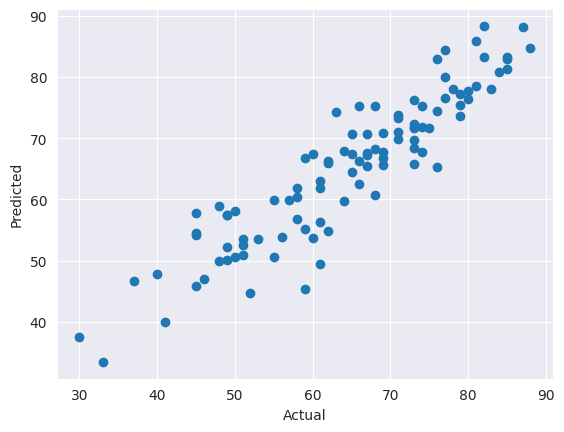

In [20]:
plt.scatter(y_val,y_pred);
plt.xlabel('Actual');
plt.ylabel('Predicted');

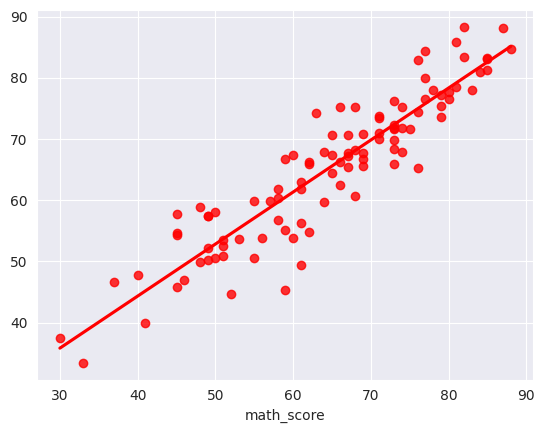

In [21]:
sns.regplot(x=y_val,y=y_pred,ci=None,color ='red');


In [22]:
pred_df=pd.DataFrame({'Actual Value':y_val,'Predicted Value':y_pred,'Difference':y_val-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
0,75,71.66,3.34
1,65,70.65,-5.65
2,62,65.90,-3.90
3,79,75.37,3.63
4,61,49.46,11.54
...,...,...,...
95,60,53.76,6.24
96,51,52.61,-1.61
97,69,65.56,3.44
98,40,47.76,-7.76
